In [1]:
import torch
import numpy as np
import argparse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from torch.nn import MSELoss, L1Loss
import os
from matplotlib import pyplot as plt

In [2]:
!pwd

/home/minghao.fu/df_work/Generative-TS-allin


In [18]:
df_raw = pd.read_csv("./datasets/AirQualityUCI.csv")
df_raw.replace(to_replace=-200, value=np.nan, inplace=True)
border = [0,int(len(df_raw)*0.8),len(df_raw)]
cols_data = df_raw.columns[2:] #change for different data
df_data = df_raw[cols_data]
data = df_data.values
test = True
if not test:
    data_x = data[border[0]:border[1]]
else:
    data_x = data[border[1]:border[2]]

orig_data = []
observed_mask = []
seq_len = 36
length = len(data_x)-seq_len+1
for i in range(length):
    orig_data.append(data_x[i:i+seq_len])
    observed_mask.append((~np.isnan(data_x[i:i+seq_len])).astype(int))
imputed_folder = "./results/aq_imputation_replicate_13/"
if test:
    imputed_path = os.path.join(imputed_folder,"test_samples.npy")
    mask_path = os.path.join(imputed_folder,"test_masks.npy")
    gt_path = os.path.join(imputed_folder,"test_gt.npy")
else:
    imputed_path = os.path.join(imputed_folder,"train_samples.npy")
    mask_path = os.path.join(imputed_folder,"train_masks.npy")
    gt_path = os.path.join(imputed_folder,"train_gt.npy")
synthetic_data = np.load(imputed_path)
gt_data = np.load(gt_path)
target_mask = np.load(mask_path)

scaler = StandardScaler()
scaler.fit(df_data[border[0]:border[1]].values)
# min_max_scaler = MinMaxScaler()
# min_max_scaler.fit(df_data[border[0]:border[1]].values)

StandardScaler()

In [19]:
target_mask.shape,gt_data.shape,synthetic_data.shape

((1837, 13, 36), (1837, 13, 36), (18370, 13, 36))

In [20]:
synthetic_data = np.reshape(synthetic_data,newshape=(gt_data.shape[0],-1,gt_data.shape[1],gt_data.shape[2]))
synthetic_data.shape

(1837, 10, 13, 36)

In [21]:
# target_mask = target_mask[::seq_len]
# gt_data = gt_data[::seq_len]
# synthetic_data = synthetic_data[::seq_len]
# target_mask.shape,gt_data.shape,synthetic_data.shape

In [22]:
low_q = np.quantile(synthetic_data,0.05,axis=1)
high_q = np.quantile(synthetic_data,0.95,axis=1)
mid_q = np.quantile(synthetic_data,0.5,axis=1)

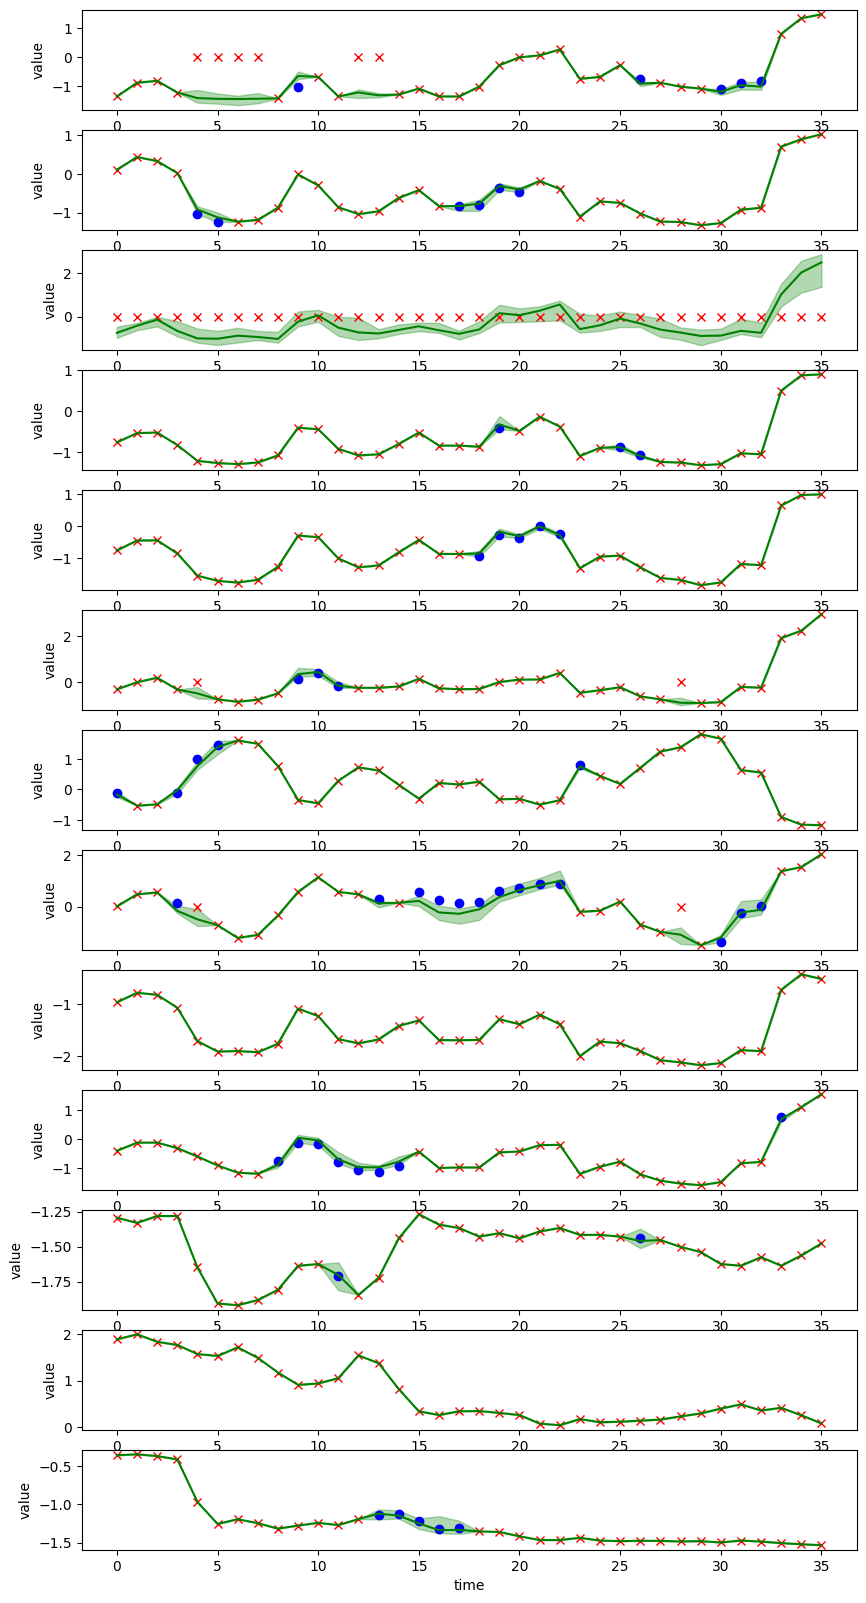

In [23]:
i = 56
feat_dim = 13 
fig, axes = plt.subplots(nrows=feat_dim, ncols=1, figsize=(10, 20))
for feat_idx in range(feat_dim):
    df_x = pd.DataFrame({"x": np.arange(0, seq_len), "val": gt_data[i, feat_idx, :],
                         "y": (1-target_mask)[i, feat_idx, :]})
    df_x = df_x[df_x.y!=0]

    df_o = pd.DataFrame({"x": np.arange(0, seq_len), "val": gt_data[i, feat_idx, :],
                         "y": target_mask[i, feat_idx, :]})
    df_o = df_o[df_o.y!=0]
    axes[feat_idx].plot(df_o.x, df_o.val, color='b', marker='o', linestyle='None')
    axes[feat_idx].plot(df_x.x, df_x.val, color='r', marker='x', linestyle='None')
    axes[feat_idx].plot(range(0, seq_len), mid_q[i, feat_idx, :], color='g', linestyle='solid', label='Diffusion-TS')
    axes[feat_idx].fill_between(range(0, seq_len), low_q[i, feat_idx,:],high_q[i,feat_idx, :], color='g', alpha = 0.3)
    plt.setp(axes[feat_idx], ylabel='value')
    if feat_idx == feat_dim-1:
        plt.setp(axes[-1], xlabel='time')
    # axes[feat_idx].set_ylim(-3, 3)
plt.show()

In [24]:
from metrics.imputation_metrics import mse_withmask, mae_withmask, calc_quantile_CRPS, calc_quantile_CRPS_sum

In [25]:
target_mask.shape

(1837, 13, 36)

In [26]:
gt_data.shape

(1837, 13, 36)

In [27]:
synthetic_data.shape

(1837, 10, 13, 36)

In [28]:
mse_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.0324)

In [29]:
torch.sqrt(mse_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask)))

tensor(0.1800)

In [30]:
mae_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.1030)

In [31]:
calc_quantile_CRPS(torch.Tensor(gt_data),torch.Tensor(synthetic_data),torch.Tensor(target_mask),mean_scaler=0,scaler=1)

0.08010066182989824

In [32]:
calc_quantile_CRPS_sum(torch.Tensor(gt_data),torch.Tensor(synthetic_data),torch.Tensor(target_mask),mean_scaler=0,scaler=1)

0.028144845837040952

In [33]:
path = os.path.join("datasets/pm25/pm25_meanstd.pk")
import pickle
with open(path, "rb") as f:
    train_mean,train_std = pickle.load(f)

In [34]:
calc_quantile_CRPS(torch.Tensor(gt_data),torch.Tensor(synthetic_data),torch.Tensor(target_mask),mean_scaler=train_mean,scaler=train_std)

0.07539166307341742

In [35]:
calc_quantile_CRPS_sum(torch.Tensor(gt_data[:,:13,:]),torch.Tensor(synthetic_data[:,:, :13,:]),torch.Tensor(target_mask[:,:13,:]),mean_scaler=train_mean,scaler=train_std)


0.021564263763138043

In [36]:
calc_quantile_CRPS_sum(torch.Tensor(gt_data),torch.Tensor(synthetic_data),torch.Tensor(target_mask),mean_scaler=train_mean,scaler=train_std)

0.021564263763138043

In [20]:
unormzalized_gt_data = []
for g in gt_data:
    unormzalized_gt_data.append(np.transpose(np.transpose(g)*scaler.scale_+scaler.mean_))
unormzalized_gt_data = np.array(unormzalized_gt_data)
unormalized_synthetic_data = []
for i in range(len(synthetic_data)):
    for j in range(len(synthetic_data[i])):
        s = synthetic_data[i][j]
        unormalized_synthetic_data.append(np.transpose(np.transpose(s)*scaler.scale_+scaler.mean_))
unormalized_synthetic_data = np.array(unormalized_synthetic_data).reshape(synthetic_data.shape[0],-1,synthetic_data.shape[2],synthetic_data.shape[3])
unormzalized_gt_data.shape,unormalized_synthetic_data.shape

((1837, 13, 36), (1837, 10, 13, 36))

In [21]:
calc_quantile_CRPS(torch.Tensor(unormzalized_gt_data),torch.Tensor(unormalized_synthetic_data),torch.Tensor(target_mask),mean_scaler=0,scaler=1)

torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) t

0.023528560211783962

In [31]:
mse_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.0415)

In [33]:
torch.sqrt(mse_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask)))

tensor(0.2036)

In [32]:
mae_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.1158)

In [34]:
mse_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask))

tensor(1164.2112)

In [35]:
torch.sqrt(mse_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask)))

tensor(34.1205)

In [36]:
mae_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask))

tensor(16.2292)